In [2]:
import geopandas as gpd
from matplotlib import pyplot as plt

In [3]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tiles_df = gpd.read_file('output/covering_tiles.kml', driver='KML')
print(repr(tiles_df.crs))
print(tiles_df)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

     Name Description                                           geometry
0                      POLYGON Z ((-120.28118 48.72093 0.00000, -118....
1                      POLYGON Z ((-119.67207 47.82260 0.00000, -118....
2                      POLYGON Z ((-119.71936 48.72091 0.00000, -118....
3                      POLYGON Z ((-113.43120 42.42690 0.00000, -112....
4                      POLYGON Z ((-112.21648 42.44624 0.00000, -110....
...   ...         ...                                                ...
1179                   POLYGON Z ((29.99818 -26.18805 0.00000, 31.096...
1180                   POLYGON Z ((136.08714 -34.33630 0.00000, 137.2...
1181                   POLYGON Z 

Remove 4
Rotate 3 to first index


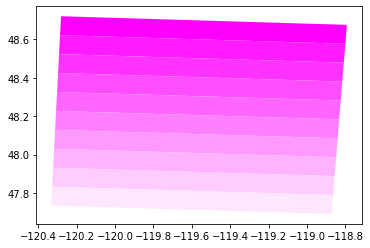

In [75]:
from shapely.geometry.multilinestring import MultiLineString
from shapely.geometry import MultiPolygon, Polygon
from shapely.geometry.linestring import LineString
from shapely.ops import split
import shapely.ops as shops
import shapely.geometry as shgeom


"""
Can't be assed to axis-align the box, so just do two separate lerps.

Given this square:
1 --> 2
^     |
|     v
0 <-- 3

left -> right: lerp 0, 1 -> 3, 2
top -> down: lerp 1, 2 -> 0, 3
"""

ax = plt.gca()
def plot_geom(geom, **kwargs):
    gpd.GeoSeries(geom).plot(ax=ax, **kwargs)

# first lerp: 0, 3 -> 1, 2
# https://stackoverflow.com/a/58284215
def split_1d(geom, n, direction):
    coords = list(geom.exterior.coords)
    if len(coords) == 5:
        for i, c in enumerate(coords):
            if i == len(coords)-1:
                d = coords[0]
            else:
                d = coords[i+1]
            if c == d:
                print('Remove', i)
                del coords[i]
                break
    assert len(coords) == 4

    min_coord_i = 0
    for i, c in enumerate(coords):
        if c[0] < coords[min_coord_i][0] and c[1] < coords[min_coord_i][1]:
            min_coord_i = i
            print('Rotate', i, 'to first index')
    coords = coords[min_coord_i:] + coords[:min_coord_i]

    # Assume the following:
    # 1. 4 coordinates are the 4 bounds of the rectangle
    # 2. Coordinates are in a linear ring
    # 3. Bottom left coordinate is at coords[0]

    splitters = []
    if direction == 'left_right':
        ls_a = LineString((coords[0], coords[3]))
        ls_b = LineString((coords[1], coords[2]))
    elif direction == 'top_down':
        ls_a = LineString((coords[1], coords[0]))
        ls_b = LineString((coords[2], coords[3]))
    else:
        raise NotImplementedError(direction)
    # Test that top and bot are correctly named
    # plot_geom(ls_bot, color='red')
    # plot_geom(ls_top, color='green')
    offset = 0.1
    for i in range(1, n):
        percent = i / n
        interp_a_ls = ls_a.interpolate(percent, normalized=True)
        interp_b_ls = ls_b.interpolate(percent, normalized=True)
        new_interp_a_ls = shgeom.Point(
            (interp_a_ls.x - ((interp_b_ls.x - interp_a_ls.x) * offset)),
            (interp_a_ls.y - ((interp_b_ls.y - interp_a_ls.y) * offset))
            )
        new_interp_b_ls = shgeom.Point(
            (interp_b_ls.x - ((interp_a_ls.x - interp_b_ls.x) * offset)),
            (interp_b_ls.y - ((interp_a_ls.y - interp_b_ls.y) * offset))
            )
        split_ls = LineString((new_interp_b_ls, new_interp_a_ls))
        splitters.append(split_ls)

    splits = []
    result = geom_0
    for splitter in splitters:
        p, q = split(result, splitter)
        result = q
        splits.append(p)
    splits.append(q)
    return splits

geom_0 = tiles_df.geometry[0]
splits = split_1d(geom_0, 10, 'top_down')
for i, s in enumerate(splits):
    plot_geom(s, color=(1, i/len(splits), 1))